In [ ]:
import json
import re
import os
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification
from transformers import AdamW, get_scheduler
from transformers import BartForSequenceClassification
from transformers import BartTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import BertTokenizer

In [136]:
class ABSADataset(Dataset):
    def __init__(self, file_path, saved_file_path = None):
        """
        Initialize the dataset by loading and preprocessing the data.
        """
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        self.model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)
        with open(file_path, 'r') as f:
            raw_data = json.load(f)  # Load raw JSON data
        if saved_file_path is not None and os.path.exists(saved_file_path):
            with open(saved_file_path, 'r') as f:
                self.data = json.load(f)  # Load preprocessed data
            print("Preprocessed data loaded from", saved_file_path)
        else:
            self.data = self.preprocess_data(raw_data)  # Preprocess and store in self.data
            if saved_file_path is not None:
                with open(saved_file_path, 'w') as f:
                    json.dump(self.data, f, indent=4)  # Save preprocessed data
                print("Preprocessed data saved to", saved_file_path)    
        
    """
    Preprocessing rule:
    - Extract the index of each token in the original sentence by taking multiple spaces into account
    - Remove leading and trailing punctuation like ,.!()-{}[]"";:
    - Remove single quotes
    - Skip words that become empty (which means they were only punctuation)
    - Allow an error range of +/- 2 tokens when matching the aspect term
    - Check if the token's prefix matches the start of the aspect term
    - Return -1 if no match is found
    """

    def preprocess_data(self, data):
        """
        Tokenizes and processes data into required format.
        """
        preprocessed_data = []
        for d in data:
            tokens = self.tokenize_data(d["sentence"])
            for term in d['aspect_terms']:
                new_data = {
                    "tokens": [t[0] for t in tokens],  # Extract token words
                    "polarity": term["polarity"],
                    "aspect_term": [term["term"]],
                    "index": self.find_aspect_index(tokens, int(term["from"]), term["term"])
                }
                preprocessed_data.append(new_data)
        return preprocessed_data

    def tokenize_data(self, sentence):
        """
        Tokenizes sentence while preserving exact indices.
        """
        tokens_idx = []
        i = 0
        word = ''
        start_idx = -1

        while i < len(sentence):
            while i < len(sentence) and sentence[i] != ' ':
                if not word:
                    start_idx = i
                word += sentence[i]
                i += 1
            if word:
                tokens_idx.append((word, start_idx))
            word = ''
            i += 1

        return self.clean_tokens(tokens_idx)

    def clean_tokens(self, tokens_idx):
        """
        Cleans tokens by removing punctuation and handling contractions.
        """
        cleaned_tokens = []
        for word, idx in tokens_idx:
            stripped_word = re.sub(r'^[.!(),\[\]{}\'":;-]+|[.!(),\[\]{}\'":;-]+$', '', word)
            stripped_word = stripped_word.replace("'", "")

            if stripped_word:  # Skip empty tokens
                cleaned_tokens.append((stripped_word.lower(), idx))
        return cleaned_tokens

    def find_aspect_index(self, tokens, aspect_from, aspect_term):
        """
        Finds the token index corresponding to the aspect term with an error range of ±2.
        """
        aspect_term = self.tokenize_data(aspect_term)
        for i in range(len(tokens)):
            if aspect_from - 2 <= tokens[i][1] <= aspect_from + 2:
                if tokens[i][0].startswith(aspect_term[0][0]):  # Check prefix match
                    return i
        return -1
    
    def get_token_embeddings(self, tokens, max_length=128, layers=[-4, -3, -2, -1]):
        """
        Get BERT embeddings for a list of tokens, ensuring a fixed shape of (max_length, 768).
        """
        encoded = self.tokenizer(
            tokens,
            return_tensors="pt",
            is_split_into_words=True,
            padding="max_length",  # ✅ Ensures fixed length
            truncation=True,
            max_length=max_length,  # ✅ Force consistent size
        )

        with torch.no_grad():
            output = self.model(**encoded)

        # Compute embeddings (sum last 4 layers)
        hidden_states = torch.stack([output.hidden_states[i] for i in layers]).sum(0).squeeze()

        # **Ensure final shape is (max_length, 768)**
        if hidden_states.shape[0] < max_length:
            pad_size = max_length - hidden_states.shape[0]
            pad_tensor = torch.zeros((pad_size, hidden_states.shape[1]))  # (pad_size, 768)
            hidden_states = torch.cat([hidden_states, pad_tensor], dim=0)  # Pad at the end

        return hidden_states[:max_length]  # ✅ Ensure shape (max_length, 768)

    def __len__(self):
        """
        Returns the total number of data samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single preprocessed data sample, including computed embeddings.
        """
        sample = self.data[idx]
        polarity_map = {"positive": 0, "neutral": 2, "negative": 1, "conflict": 3}

        # Get sentence embeddings (shape: (max_length, 768))
        embeddings = self.get_token_embeddings(sample["tokens"], max_length=128)  # Max length 128

        # Get aspect term embeddings (shape: (aspect_max_length, 768))
        aspect_tokens = self.tokenize_data(sample["aspect_term"][0])  # Tokenize aspect term
        aspect_embedding = self.get_token_embeddings([t[0] for t in aspect_tokens], max_length=8)  # Max length 8
        # print("Sample:", sample["tokens"])
        # print("Aspect term embedding:", aspect_embedding.shape)
        # print("Token embedding:", embeddings.shape)
        return {
            "tokens": sample["tokens"],
            "embeddings": torch.tensor(embeddings, dtype=torch.float),  # Shape: (128, 768)
            "polarity": torch.tensor(polarity_map[sample["polarity"]], dtype=torch.long),  # Shape: ()
            "aspect_term":  torch.tensor(aspect_embedding, dtype=torch.float),
            "index": torch.tensor(sample["index"], dtype=torch.long),  # Shape: ()
        }


In [137]:
train_dataset = ABSADataset("train.json", "train_task_2.json")
val_dataset = ABSADataset("val.json", "val_task_2.json")

Preprocessed data loaded from train_task_2.json
Preprocessed data loaded from val_task_2.json


In [138]:
max_train_length = max([len(d["tokens"]) for d in train_dataset.data])
max_val_length = max([len(d["tokens"]) for d in val_dataset.data])
print("Max train length:", max_train_length)
print("Max val length:", max_val_length)

Max train length: 69
Max val length: 48


In [139]:
print(len(train_dataset))
print(len(val_dataset)) 
print(train_dataset[0])
print(val_dataset[0])  

2961
371


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6068\3109388899.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "embeddings": torch.tensor(embeddings, dtype=torch.float),  # Shape: (128, 768)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6068\3109388899.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "aspect_term":  torch.tensor(aspect_embedding, dtype=torch.float),


{'tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us'], 'embeddings': tensor([[ 1.9976,  3.0614, -2.7381,  ..., -1.5977,  1.8881, -0.6945],
        [ 2.2932,  2.6890, -0.3895,  ...,  2.1881, -1.1270, -0.5891],
        [-0.4416, -0.6662, -2.2985,  ...,  1.4890, -1.8471,  3.0896],
        ...,
        [-3.3617,  1.8583, -0.7389,  ..., -0.9075, -1.0788, -2.5828],
        [-2.9848,  1.6417, -1.2289,  ..., -1.4844, -1.8254, -3.1934],
        [-3.0569,  1.6146, -1.7832,  ..., -1.0309, -2.0181, -3.6214]]), 'polarity': tensor(1), 'aspect_term': tensor([[ 0.9993, -1.1836, -1.4425,  ..., -1.0973,  1.5845,  1.2668],
        [ 2.5821, -4.1148, -0.4606,  ..., -3.3853, -0.1479,  0.3372],
        [ 0.2073,  0.8993,  0.4269,  ..., -0.0397,  0.8534, -0.5007],
        ...,
        [ 0.7302, -2.3626, -0.5775,  ..., -1.7317, -1.3500,  2.5714],
        [ 0.5360, -2.1273, -0.7242,  ..., -1.6414, -0.6824,  2.7984],
        [ 0.6539, -1.3669, -2.6096,  ..., -0.8288,  1.8169,  4.2203]]), 'inde

Reference: https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958

https://discuss.huggingface.co/t/huggingface-dataset-each-element-in-list-of-batch-should-be-of-equal-size/10697/6

https://medium.com/@xiaohan_63326/fine-tune-fine-tuning-bert-for-sentiment-analysis-f5002b08f10a

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_layers=2, output_dim=4, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        
        # **Fix: Change input size from 256 -> 768**
        self.aspect_fc = nn.Linear(input_dim, hidden_dim)  # Now correctly maps 768 -> 256

        self.fc = nn.Linear(hidden_dim * 3, output_dim)  # Combine LSTM + aspect
        self.dropout = nn.Dropout(dropout)

    def forward(self, sentence_embeddings, aspect_embeddings, aspect_index):
        # Process sentence embeddings through LSTM
        lstm_out, (hidden, _) = self.lstm(sentence_embeddings)  
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Shape: (batch_size, hidden_dim * 2)

        # **Fix: Mean-pool aspect embeddings (now shape is (batch_size, 768))**
        aspect_rep = aspect_embeddings.mean(dim=1)  # Shape: (batch_size, 768)
        aspect_rep = self.aspect_fc(aspect_rep)  # **Maps (batch_size, 768) → (batch_size, 256)**

        # **Ensure tensors have matching dimensions before concatenation**
        combined = torch.cat((hidden, aspect_rep), dim=1)  # Shape: (batch_size, hidden_dim * 3)

        out = self.fc(self.dropout(combined))
        return out


In [141]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    best_acc = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for sentence_embeddings, aspect_embeddings, labels, aspect_index in tqdm_bar:
            sentence_embeddings = sentence_embeddings.to(device)  # ✅ No need for batch["embeddings"]
            aspect_embeddings = aspect_embeddings.to(device)
            labels = labels.to(device)
            aspect_index = aspect_index.to(device)# Shape: (batch_size,)

            optimizer.zero_grad()
            outputs = model(sentence_embeddings, aspect_embeddings, aspect_index)  # ✅ Pass all inputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tqdm_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_acc = correct / total
        train_accuracy.append(train_acc)
        train_loss.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_total_loss, correct, total = 0, 0, 0

        tqdm_bar_val = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}", leave=False)
        with torch.no_grad():
            for sentence_embeddings, aspect_embeddings, labels, aspect_index in tqdm_bar_val:
                sentence_embeddings = sentence_embeddings.to(device)  # ✅ No need for batch["embeddings"]
                aspect_embeddings = aspect_embeddings.to(device)
                labels = labels.to(device)
                aspect_index = aspect_index.to(device)

                outputs = model(sentence_embeddings, aspect_embeddings, aspect_index)  # ✅ Pass all inputs
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                tqdm_bar_val.set_postfix(loss=f"{loss.item():.4f}")

        val_acc = correct / total
        val_accuracy.append(val_acc)
        val_loss.append(val_total_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss[-1]:.4f} - Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_lstm_model.pth")
            print("🔥 Best model saved!")

    print(f"🎉 Training complete. Best Validation Accuracy: {best_acc:.4f}")
    return train_loss, val_loss, train_accuracy, val_accuracy


In [2]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0, max(max(train_loss), max(val_loss)) * 1.1)  # ✅ Y-axis starts from 0
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)  # ✅ Accuracy should be between 0 and 1
    plt.legend()

    plt.tight_layout()
    plt.show()

In [143]:
def collate_fn(batch):
    """
    Custom collate function to batch fixed-length embeddings for ABSADataset.
    """
    sentence_embeddings = torch.stack([item["embeddings"] for item in batch])  # (batch_size, 128, 768)
    aspect_embeddings = torch.stack([item["aspect_term"] for item in batch])  # (batch_size, 8, 768)
    labels = torch.tensor([item["polarity"] for item in batch], dtype=torch.long)  # (batch_size,)
    indices = torch.tensor([item["index"] for item in batch], dtype=torch.long)  # (batch_size,)

    return sentence_embeddings, aspect_embeddings, labels, indices


In [144]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [145]:
model = LSTMClassifier()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=5, lr=0.001)

Epoch 1/5:   0%|          | 0/93 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_6068\3109388899.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "embeddings": torch.tensor(embeddings, dtype=torch.float),  # Shape: (128, 768)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6068\3109388899.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "aspect_term":  torch.tensor(aspect_embedding, dtype=torch.float),


Epoch 1/5 - Train Loss: 0.9810 - Train Acc: 0.6184 - Val Loss: 0.9233 - Val Acc: 0.6496
🔥 Best model saved!


Epoch 2/5 - Train Loss: 0.6623 - Train Acc: 0.7430 - Val Loss: 0.9208 - Val Acc: 0.6631
🔥 Best model saved!


Epoch 3/5 - Train Loss: 0.5476 - Train Acc: 0.7933 - Val Loss: 0.9059 - Val Acc: 0.6388


Epoch 4/5 - Train Loss: 0.5229 - Train Acc: 0.8024 - Val Loss: 0.9353 - Val Acc: 0.6442


Epoch 5/5 - Train Loss: 0.4510 - Train Acc: 0.8261 - Val Loss: 1.0320 - Val Acc: 0.6739
🔥 Best model saved!
🎉 Training complete. Best Validation Accuracy: 0.6739


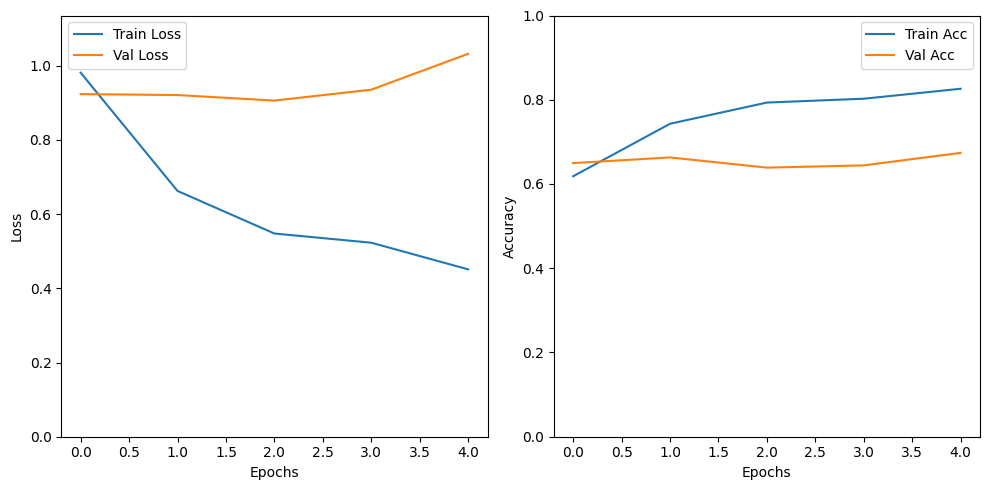

In [154]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [150]:
def load_and_evaluate(model_path = "best_lstm_model.pth", test_file = "val_task_2.json", batch_size=16):
    """
    Load the trained model and evaluate it on test data.

    Args:
        model_path (str): Path to the saved model file.
        test_file (str): Path to the test dataset.
        batch_size (int): Batch size for evaluation.

    Returns:
        float: Test accuracy.
    """

    # Load test dataset
    test_dataset = ABSADataset("val.json", test_file)
    
    # Ensure collate_fn is used to handle variable-length sequences
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Define model
    model = LSTMClassifier(output_dim=4)  # Ensure output_dim matches trained model

    # Load saved model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode

    correct, total = 0, 0
    with torch.no_grad():
        tqdm_bar = tqdm(test_loader, desc="Evaluating")
        for sentence_embeddings, aspect_embeddings, labels, aspect_index in tqdm_bar:
            outputs = model(sentence_embeddings, aspect_embeddings, aspect_index)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"✅ Test Accuracy: {accuracy:.2f}%")
    return accuracy

load_and_evaluate()

Preprocessed data loaded from val_task_2.json


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_6068\3109388899.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "embeddings": torch.tensor(embeddings, dtype=torch.float),  # Shape: (128, 768)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6068\3109388899.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "aspect_term":  torch.tensor(aspect_embedding, dtype=torch.float),
Evaluating: 100%|██████████| 24/24 [02:33<00:00,  6.40s/it]

✅ Test Accuracy: 67.39%


67.38544474393531

Finetuning BERT

In [ ]:
class FinetuneDataset(Dataset):
    def __init__(self, model, file_path):
        """
        Load and preprocess dataset for fine-tuning BERT.
        """
        if model == "bert":
            self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
        elif model == "bart":
            self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
        elif model == "roberta":
            self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        else:  
            raise ValueError("Invalid model name. Choose from 'bert', 'bart', or 'roberta'.")
        
        with open(file_path, 'r') as f:
            self.data = json.load(f)  

        self.polarity_map = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}
        
    def tokenize_data(self, sentence):
        """
        Tokenizes sentence while preserving exact indices.
        """
        tokens_idx = []
        i = 0
        word = ''
        start_idx = -1

        while i < len(sentence):
            while i < len(sentence) and sentence[i] != ' ':
                if not word:
                    start_idx = i
                word += sentence[i]
                i += 1
            if word:
                tokens_idx.append((word, start_idx))
            word = ''
            i += 1

        return self.clean_tokens(tokens_idx)

    def clean_tokens(self, tokens_idx):
        """
        Cleans tokens by removing punctuation and handling contractions.
        """
        cleaned_tokens = []
        for word, idx in tokens_idx:
            stripped_word = re.sub(r'^[.!(),\[\]{}\'":;-]+|[.!(),\[\]{}\'":;-]+$', '', word)
            stripped_word = stripped_word.replace("'", "")

            if stripped_word:  # Skip empty tokens
                cleaned_tokens.append((stripped_word.lower(), idx))
        return cleaned_tokens

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns pre-tokenized input as BERT-compatible token IDs.
        """
        sample = self.data[idx]
        tokenized_words = sample["tokens"]  # Already tokenized from `tokenize_data()`
        aspect_term = sample["aspect_term"][0]
        label = self.polarity_map[sample["polarity"]]
        if isinstance(self.tokenizer, BartTokenizer):
            tokenized_words.append("</s>")

        # **Convert pre-tokenized words into token IDs**
        input_ids = self.tokenizer.convert_tokens_to_ids(tokenized_words)
        aspect_ids = self.tokenizer.convert_tokens_to_ids([t[0] for t in self.tokenize_data(aspect_term)])

        # **Pad sequences to max_length**
        max_length = 128
        input_ids = input_ids[:max_length] + [self.tokenizer.pad_token_id] * (max_length - len(input_ids))
        aspect_ids = aspect_ids[:8] + [self.tokenizer.pad_token_id] * (8 - len(aspect_ids))

        # **Create attention masks (1 for real tokens, 0 for padding)**
        attention_mask = [1 if id != self.tokenizer.pad_token_id else 0 for id in input_ids]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),  # Shape: (max_length,)
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "aspect_ids": torch.tensor(aspect_ids, dtype=torch.long),  # Shape: (8,)
            "label": torch.tensor(label, dtype=torch.long),  # Shape: ()
        }

In [ ]:
def finetune(model, train_loader, val_loader, epochs=5, lr=2e-5, model_name="bert"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=epochs * len(train_loader))
    criterion = torch.nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    best_acc = 0.0
    train_accuracy = []
    val_accuracy = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for batch in tqdm_bar:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tqdm_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_acc = correct / total
        train_accuracy.append(train_acc)
        train_losses.append(total_loss / len(train_loader))
        print(f"✅ Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Accuracy = {train_acc:.4f}")

        # Validation
        model.eval()
        correct, total = 0, 0
        val_loss = 0

        tqdm_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")  # ✅ Add tqdm for validation
        with torch.no_grad():
            for batch in tqdm_bar_val:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                tqdm_bar_val.set_postfix(loss=f"{loss.item():.4f}")

        val_acc = correct / total
        val_accuracy.append(val_acc)
        val_losses.append(val_loss / len(val_loader))
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}_model.pth")
            print("🔥 Best model saved!")

        print(f"📌 Epoch {epoch+1}: Val Loss = {val_losses[-1]:.4f}, Val Accuracy = {val_acc:.4f}")

    print(f"\n🎉 Training complete. Best Validation Accuracy: {best_acc:.4f}")
    return train_losses, val_losses, train_accuracy, val_accuracy


In [ ]:
# Load dataset
train_dataset = FinetuneDataset("bert", "train_task_2.json")
val_dataset = FinetuneDataset("bert", "val_task_2.json")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=4)

# Train
train_loss, val_loss, train_acc, val_acc = finetune(model, train_loader, val_loader, epochs=5, lr=2e-5, model_name = "bert")


In [ ]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

Finetune BART

In [ ]:
# Load dataset
train_dataset = FinetuneDataset("bart", "train_task_2.json")
val_dataset = FinetuneDataset("bart", "val_task_2.json")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Load BART Model
model = BartForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=4)

# Train
train_loss, val_loss, train_acc, val_acc = finetune(model, train_loader, val_loader, epochs=5, lr=2e-5, model_name = "bart")

In [ ]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

Finetune Roberta

In [ ]:
# Load dataset
train_dataset = FinetuneDataset("roberta", "train_task_2.json")
val_dataset = FinetuneDataset("roberta", "val_task_2.json")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Load BART Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Train
train_loss, val_loss, train_acc, val_acc = finetune(model, train_loader, val_loader, epochs=5, lr=2e-5, model_name = "roberta")

In [ ]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)